# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import re
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('tweet_sentiment_train.csv.zip')
# D:\GitHub\ML-Course\homework\Topic4\tweet_sentiment_train.csv.zip

df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [3]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11118


In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [5]:
df.isna().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [6]:
df.sentiment.value_counts(normalize=True),df.sentiment.value_counts()

(sentiment
 neutral     0.404549
 positive    0.312300
 negative    0.283151
 Name: proportion, dtype: float64,
 sentiment
 neutral     11117
 positive     8582
 negative     7781
 Name: count, dtype: int64)

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: character_count, dtype: float64

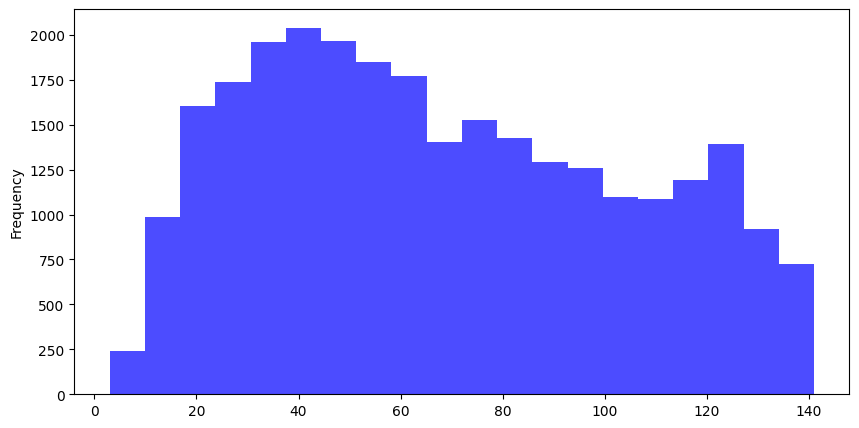

In [7]:
df_enrich = df.copy()
df_enrich['character_count'] = df_enrich['text'].apply(lambda x: len(x))
df_enrich.character_count.plot(kind='hist', bins=20, figsize=(10, 5), color='blue', alpha=0.7)
df_enrich.character_count.describe()

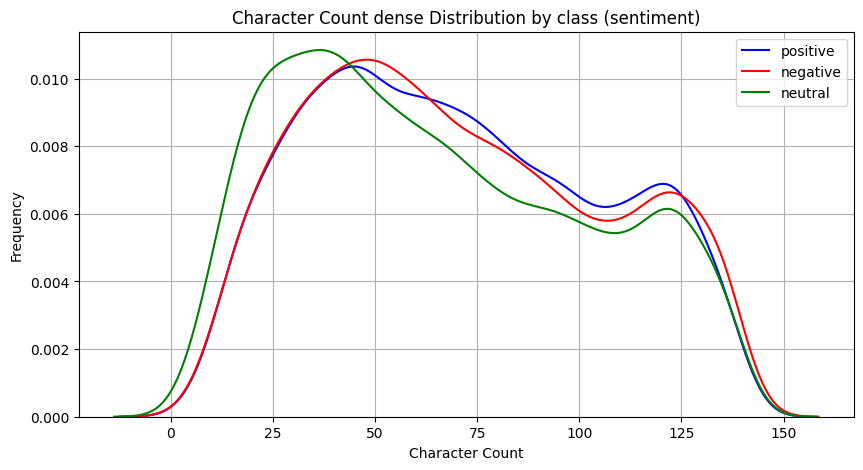

In [8]:
plt.figure(figsize=(10, 5))
plt.title('Character Count dense Distribution by class (sentiment)') 
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid()
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'positive'], label='positive', color='blue')
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'negative'], label='negative', color='red')
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'neutral'], label='neutral', color = 'green')
plt.legend()
plt.show()


### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem.snowball import SnowballStemmer


In [10]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
english_stopwords = stopwords.words('english')
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in english_stopwords]

In [12]:
stemmer = SnowballStemmer(language='english')

In [13]:
import re
def tokenize(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'http\S+|www\S+', '', text) # remove URLs
    text = re.sub(r'[^a-z\s]', '', text) # remove punctuation and special characters
    tokens = word_tokenize(text)

    tokens = remove_stopwords(tokens) # remove stopwords
    stem = [stemmer.stem(word) for word in tokens if word not in english_stopwords] # stemming
    return stem

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
vect = CountVectorizer(tokenizer=tokenize, 
                           stop_words=english_stopwords, 
                           max_features=2000, 
                           ngram_range=(1, 2), 
                           lowercase=True
                           )
vect.fit(df.text)


d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'theyd', 'theyll', 'theyr', 'theyv', 'wasnt', 'wed', 'well', 'werent', 'weve', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=2000, ngram_range=(1, 2),
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x000001D968977EC0>)

In [16]:
vect.get_feature_names_out()[:100], vect.get_feature_names_out()[-100:]

(array(['abl', 'absolut', 'abt', 'ac', 'accept', 'access', 'accid',
        'account', 'ace', 'ach', 'across', 'act', 'action', 'activ',
        'actual', 'ad', 'add', 'addict', 'admit', 'ador', 'advic',
        'afford', 'afraid', 'afternoon', 'age', 'ago', 'agre', 'ah', 'aha',
        'ahead', 'ahh', 'ahhh', 'ahhhh', 'aim', 'aint', 'air', 'airport',
        'alarm', 'album', 'alcohol', 'alex', 'allergi', 'allow', 'almost',
        'alon', 'along', 'alot', 'alreadi', 'alright', 'also', 'although',
        'alway', 'amaz', 'america', 'american', 'angel', 'anim', 'announc',
        'annoy', 'anoth', 'anoth one', 'answer', 'anybodi', 'anymor',
        'anyon', 'anyth', 'anytim', 'anyway', 'apart', 'app', 'appar',
        'appear', 'appl', 'appli', 'appreci', 'area', 'arent', 'argh',
        'arm', 'around', 'arriv', 'art', 'articl', 'asap', 'ashley', 'ask',
        'asleep', 'assign', 'aswel', 'ate', 'atm', 'attack', 'attempt',
        'attend', 'attent', 'august', 'australia', 'avail', 

In [17]:
inputs = vect.transform(df.text)    

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [18]:
inputs.shape, df.shape

((27480, 2000), (27480, 4))

In [19]:
train_index, test_index = train_test_split(df.index, test_size=0.2, stratify=df.sentiment, random_state=42)
X_train_bow = inputs[train_index]
X_test_bow = inputs[test_index]
y_train = df.sentiment[train_index]
y_test = df.sentiment[test_index]

X_train_bow.shape, X_test_bow.shape, y_train.shape, y_test.shape    

((21984, 2000), (5496, 2000), (21984,), (5496,))

In [20]:
labels = ['negative','neutral','positive']
encoder = LabelEncoder()
encoder.fit(labels)
y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [21]:
def evaluate_model(model, inputs, targets, name=''):
  y_preds = model.predict(inputs)
  # labels = model.classes_
  labels_tex = ['negative','neutral','positive']

  print(classification_report(targets, y_preds, target_names=labels))
  f1 = f1_score(targets, y_preds, average='weighted')
  print("F1 score: {:.2f}".format(f1))

  cm = confusion_matrix(targets, y_preds, normalize='true')

  plt.figure()
  ax = sns.heatmap(cm, annot=True, cmap = 'Blues',
                   xticklabels=labels_tex, yticklabels=labels_tex)
  plt.xlabel('Prediction')
  plt.ylabel('Target')
  plt.title('{} Confusion Matrix'.format(name))
  plt.show()

              precision    recall  f1-score   support

    negative       0.74      0.74      0.74      6225
     neutral       0.74      0.74      0.74      8894
    positive       0.80      0.81      0.80      6865

    accuracy                           0.76     21984
   macro avg       0.76      0.76      0.76     21984
weighted avg       0.76      0.76      0.76     21984

F1 score: 0.76


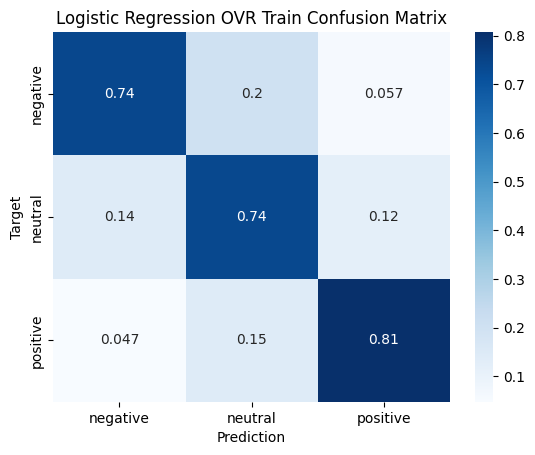

              precision    recall  f1-score   support

    negative       0.67      0.68      0.68      1556
     neutral       0.66      0.66      0.66      2223
    positive       0.75      0.74      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.69      0.69      0.69      5496
weighted avg       0.69      0.69      0.69      5496

F1 score: 0.69


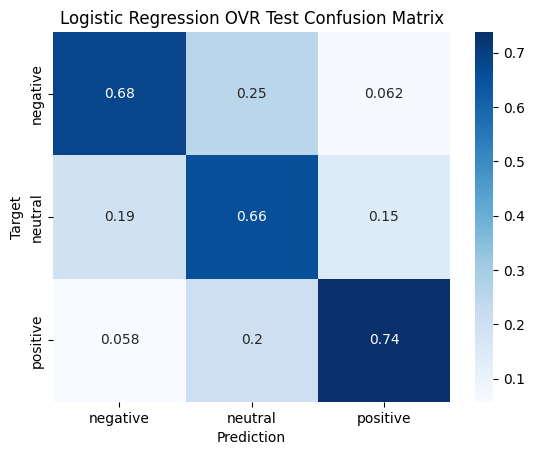

In [22]:
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000, solver='saga')
ovr_model = OneVsRestClassifier(lr)
ovr_model.fit(X_train_bow, y_train_encoded)
evaluate_model(ovr_model, X_train_bow, y_train_encoded, 'Logistic Regression OVR Train')
evaluate_model(ovr_model, X_test_bow, y_test_encoded, 'Logistic Regression OVR Test')

In [23]:
# Decision Tree Classifier

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 40, 2),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}
dt = DecisionTreeClassifier(random_state=42)
randomSearch = RandomizedSearchCV(estimator=dt,
                           param_distributions=params,
                           n_iter=50,
                           scoring='f1_weighted',
                           cv=3,
                           verbose=1,
                           n_jobs=-1
                          )
randomSearch.fit(X_train_bow, y_train_encoded)
best_params = randomSearch.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best parameters found:  {'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': np.int64(38), 'criterion': 'entropy', 'class_weight': 'balanced'}
              precision    recall  f1-score   support

    negative       0.59      0.23      0.33      6225
     neutral       0.50      0.83      0.62      8894
    positive       0.75      0.51      0.61      6865

    accuracy                           0.56     21984
   macro avg       0.61      0.52      0.52     21984
weighted avg       0.60      0.56      0.54     21984

F1 score: 0.54


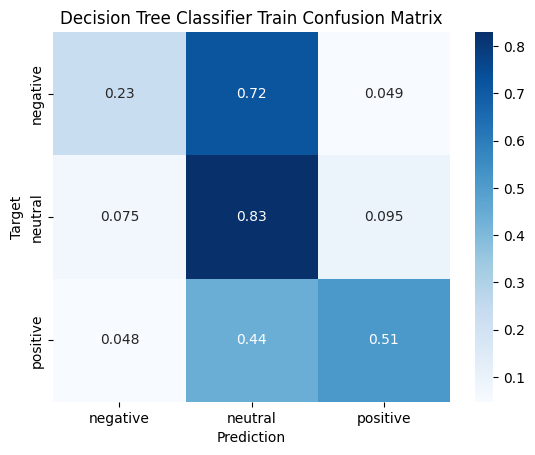

              precision    recall  f1-score   support

    negative       0.55      0.22      0.31      1556
     neutral       0.49      0.82      0.61      2223
    positive       0.75      0.51      0.61      1717

    accuracy                           0.55      5496
   macro avg       0.60      0.52      0.51      5496
weighted avg       0.59      0.55      0.53      5496

F1 score: 0.53


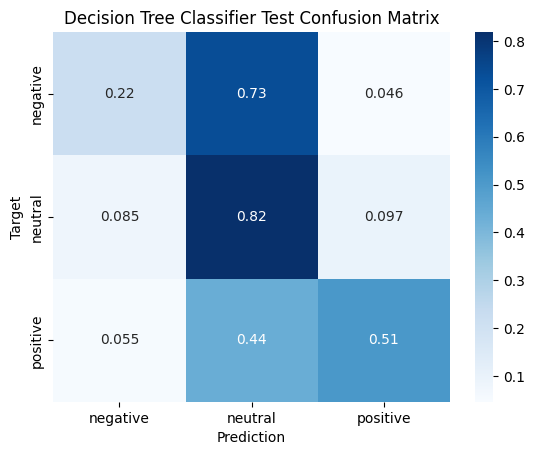

In [24]:
print("Best parameters found: ", best_params)
dt_best = randomSearch.best_estimator_
evaluate_model(dt_best, X_train_bow, y_train_encoded, 'Decision Tree Classifier Train')
evaluate_model(dt_best, X_test_bow, y_test_encoded, 'Decision Tree Classifier Test')

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:14:09] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    negative       0.88      0.73      0.80      6225
     neutral       0.76      0.89      0.82      8894
    positive       0.88      0.83      0.85      6865

    accuracy                           0.83     21984
   macro avg       0.84      0.82      0.82     21984
weighted avg       0.83      0.83      0.83     21984

F1 score: 0.83


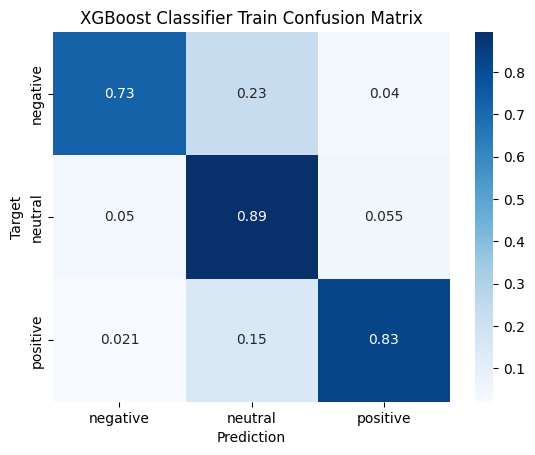

              precision    recall  f1-score   support

    negative       0.73      0.62      0.67      1556
     neutral       0.65      0.75      0.69      2223
    positive       0.77      0.72      0.74      1717

    accuracy                           0.70      5496
   macro avg       0.72      0.70      0.70      5496
weighted avg       0.71      0.70      0.70      5496

F1 score: 0.70


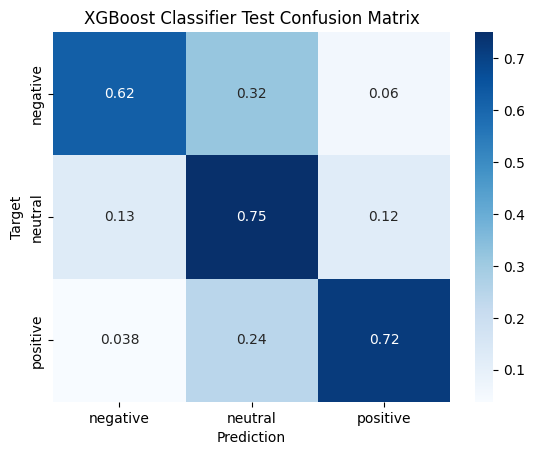

CPU times: total: 1min 33s
Wall time: 7.72 s


In [25]:
%%time
# XGBoost Classifier
# params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': np.arange(2, 40, 2),
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.5, 0.7, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'class_weight': ['balanced', None]
# }

xgb = XGBClassifier(random_state=42,
                    learning_rate=0.1, 
                    n_estimators=400, 
                    max_depth=15, subsample=0.8, 
                    gamma=0.1, class_weight='balanced',
                    )   
xgb.fit(X_train_bow, y_train_encoded)

evaluate_model(xgb, X_train_bow, y_train_encoded, 'XGBoost Classifier Train')
evaluate_model(xgb, X_test_bow, y_test_encoded, 'XGBoost Classifier Test')

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [26]:
feature_importances = xgb.feature_importances_
feature_names = vect.get_feature_names_out()
df_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
df_importances = df_importances.sort_values(by='importance', ascending=False)
display(df_importances.head(20))

,feature,importance
790,happi,0.005929
1727,thank,0.005224
798,hate,0.004018
52,amaz,0.003953
875,hurt,0.003604
1475,sad,0.003314
1242,nice,0.003244
104,awesom,0.003239
566,fail,0.003139
551,excit,0.003112


### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [27]:
tfidf_vect = TfidfVectorizer(tokenizer=tokenize,
                           stop_words=english_stopwords, 
                           max_features=2000, 
                           ngram_range=(1, 2), 
                           lowercase=True
                           )
tfidf_vect.fit(df.text)
inputs_tfidf = tfidf_vect.transform(df.text)
inputs_tfidf.shape, df.shape

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'theyd', 'theyll', 'theyr', 'theyv', 'wasnt', 'wed', 'well', 'werent', 'weve', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  warnings.warn(


((27480, 2000), (27480, 4))

In [28]:
X_train_tfidf = inputs_tfidf[train_index]
X_test_tfidf = inputs_tfidf[test_index]

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:14:26] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    negative       0.93      0.79      0.85      6225
     neutral       0.80      0.93      0.86      8894
    positive       0.92      0.86      0.89      6865

    accuracy                           0.87     21984
   macro avg       0.89      0.86      0.87     21984
weighted avg       0.88      0.87      0.87     21984

F1 score: 0.87


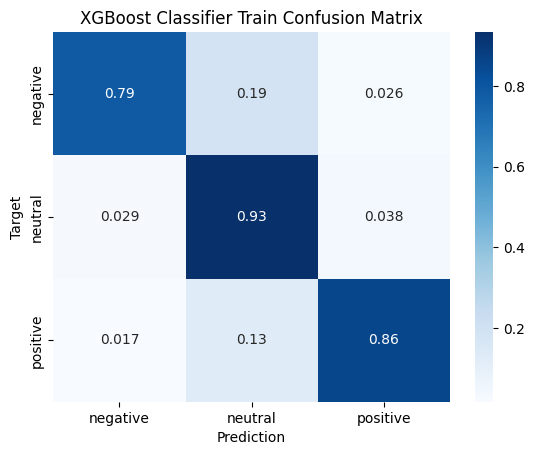

              precision    recall  f1-score   support

    negative       0.72      0.61      0.66      1556
     neutral       0.63      0.73      0.68      2223
    positive       0.76      0.72      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.69      0.69      5496
weighted avg       0.70      0.69      0.69      5496

F1 score: 0.69


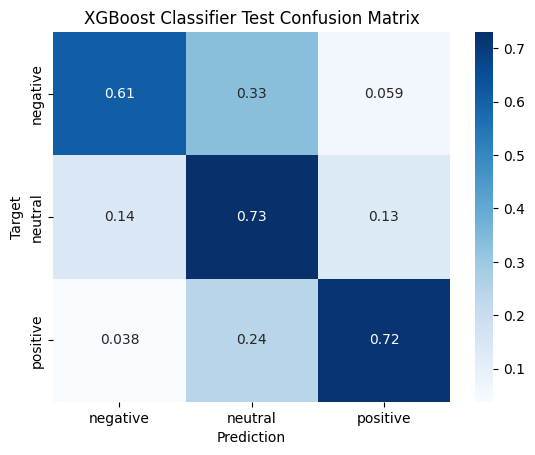

CPU times: total: 18min 43s
Wall time: 1min 31s


In [29]:
%%time
xgb_tfifd = XGBClassifier(random_state=42,
                    learning_rate=0.1, 
                    n_estimators=400, 
                    max_depth=15, subsample=0.8, 
                    gamma=0.1, class_weight='balanced',
                    )   
xgb_tfifd.fit(X_train_tfidf, y_train_encoded)

evaluate_model(xgb_tfifd, X_train_tfidf, y_train_encoded, 'XGBoost Classifier Train')
evaluate_model(xgb_tfifd, X_test_tfidf, y_test_encoded, 'XGBoost Classifier Test')

In [30]:
feature_importances_tf = xgb_tfifd.feature_importances_
feature_names_tf = tfidf_vect.get_feature_names_out()
df_importances_tf = pd.DataFrame({'feature': feature_names_tf, 'importance': feature_importances_tf})
df_importances_tf = df_importances_tf.sort_values(by='importance', ascending=False)
display(df_importances_tf.head(20))

,feature,importance
790,happi,0.005394
1727,thank,0.003936
875,hurt,0.003841
798,hate,0.003376
1661,suck,0.003349
1475,sad,0.003232
52,amaz,0.003222
104,awesom,0.002873
566,fail,0.002857
1658,stupid,0.002709


In [31]:
print("XGBoost Classifier with TF-IDF features")
print((df_importances_tf.feature[:10]).tolist())
print("XGBoost Classifier with BoW features")
print((df_importances.feature[:10]).tolist()) 

XGBoost Classifier with TF-IDF features
['happi', 'thank', 'hurt', 'hate', 'suck', 'sad', 'amaz', 'awesom', 'fail', 'stupid']
XGBoost Classifier with BoW features
['happi', 'thank', 'hate', 'amaz', 'hurt', 'sad', 'nice', 'awesom', 'fail', 'excit']


In [32]:
perd_proba_tfidf = xgb_tfifd.predict_proba(X_test_tfidf)
pred_proba_bow = xgb.predict_proba(X_test_bow)
display(np.round(perd_proba_tfidf[:5], 4), np.round(pred_proba_bow[:5], 4))

array([[0.286 , 0.5775, 0.1365],
       [0.9256, 0.0658, 0.0087],
       [0.7463, 0.2259, 0.0279],
       [0.9723, 0.0233, 0.0044],
       [0.0328, 0.2332, 0.734 ]], dtype=float32)

array([[0.4125, 0.4303, 0.1572],
       [0.9246, 0.0721, 0.0034],
       [0.9901, 0.0089, 0.001 ],
       [0.8478, 0.1399, 0.0123],
       [0.0337, 0.3525, 0.6137]], dtype=float32)

In [51]:
# FOR future work 
# shap.plots.text() is strictly for models that take raw text input, not bag-of-words (BoW) or other numeric feature representations.
# -->> check alternative plots for BoW or TF-IDF representations.
#  import shap

# X_train_bow_dense = X_train_bow.toarray()
# X_test_bow_dense = X_test_bow.toarray()
# explainer = shap.Explainer(xgb, X_train_bow_dense)

# # Compute SHAP values for the test set
# shap_values = explainer(X_test_bow_dense[:100])

# shap.plots.text(shap_values[0])

In [ ]:
# X_train_tfidf_dense = X_train_tfidf.toarray()
# X_test_tfidf_dense = X_test_tfidf.toarray()
# explainer_tfidf = shap.Explainer(xgb_tfifd, X_train_tfidf_dense)

# # Compute SHAP values for the test set
# shap_values_tfidf = explainer_tfidf(X_test_tfidf_dense)
# shap.plots.text(shap_values_tfidf[example_index])


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [332]:
df_results = pd.DataFrame({'text': df.text[test_index], 'sentiment': y_test, 'pred_proba_tfidf': (perd_proba_tfidf).tolist(), 'pred_proba_bow': pred_proba_bow.tolist()})
df_results['pred_tfidf'] = df_results['pred_proba_tfidf'].apply(lambda x: encoder.inverse_transform([np.argmax(x)])[0])
df_results['pred_bow'] = df_results['pred_proba_bow'].apply(lambda x: encoder.inverse_transform([np.argmax(x)])[0])
df_results.head()

,text,sentiment,pred_proba_tfidf,pred_proba_bow,pred_tfidf,pred_bow
23413,Reading and taking notes but undertanding none...,negative,"[0.23980587720870972, 0.6495123505592346, 0.11...","[0.3530365526676178, 0.4824366867542267, 0.164...",neutral,neutral
27363,so sad emma u sad to be leaving the show? ****,negative,"[0.9126591682434082, 0.07573284208774567, 0.01...","[0.9253812432289124, 0.07102824747562408, 0.00...",negative,negative
21260,Freakin` frustrated why can`t my coach realize...,negative,"[0.7365989685058594, 0.23586933314800262, 0.02...","[0.9920835494995117, 0.0069602737203240395, 0....",negative,negative
11166,is feeling so bored... i miss school time,negative,"[0.9683890342712402, 0.02767253667116165, 0.00...","[0.8767223954200745, 0.11252787709236145, 0.01...",negative,negative
24608,wow this morning 8.15 hrs ding dong breakfasts...,positive,"[0.0356130413711071, 0.23586197197437286, 0.72...","[0.03357294946908951, 0.34997978806495667, 0.6...",positive,positive


In [333]:
df_tfidf_results = df_results.copy()
df_tfidf_results.drop(columns=['pred_bow','pred_proba_bow'], inplace=True)
df_tfidf_results['pred_proba_tfidf'] = df_tfidf_results['pred_proba_tfidf'].apply(lambda x: np.round(x, 4))
df_tfidf_results

,text,sentiment,pred_proba_tfidf,pred_tfidf
23413,Reading and taking notes but undertanding none...,negative,"[0.2398, 0.6495, 0.1107]",neutral
27363,so sad emma u sad to be leaving the show? ****,negative,"[0.9127, 0.0757, 0.0116]",negative
21260,Freakin` frustrated why can`t my coach realize...,negative,"[0.7366, 0.2359, 0.0275]",negative
11166,is feeling so bored... i miss school time,negative,"[0.9684, 0.0277, 0.0039]",negative
24608,wow this morning 8.15 hrs ding dong breakfasts...,positive,"[0.0356, 0.2359, 0.7285]",positive
...,...,...,...,...
16888,Chilling with Colton who just redesigned the C...,positive,"[0.1595, 0.5735, 0.267]",neutral
11409,i guess that means you didn`t beta-read eithe...,neutral,"[0.3198, 0.6555, 0.0247]",neutral
18662,"Just eaten, and feel extremely bloated... now...",negative,"[0.2308, 0.072, 0.6972]",positive
2959,Up early so washed and waxed the car. I`m sure...,neutral,"[0.5656, 0.3374, 0.0971]",negative


In [334]:
df_tfidf_results[df_tfidf_results['sentiment'] != df_tfidf_results['pred_tfidf']].head(10)

,text,sentiment,pred_proba_tfidf,pred_tfidf
23413,Reading and taking notes but undertanding none...,negative,"[0.2398, 0.6495, 0.1107]",neutral
4126,Hoping that this will just heal on it`s own be...,neutral,"[0.1917, 0.2814, 0.5269]",positive
20626,i`m just sooo in love....i think,positive,"[0.192, 0.6262, 0.1819]",neutral
4831,yum. Do you do home delivery,positive,"[0.0911, 0.5097, 0.3992]",neutral
19359,Having a wonderful piece of cake for lunch - w...,positive,"[0.1531, 0.6, 0.2469]",neutral
10651,shack idol today(: can`t wait. it`s gonna be f...,neutral,"[0.8235, 0.1669, 0.0096]",negative
17483,"Awww, *hugs* I wish I could help.",negative,"[0.0712, 0.0957, 0.833]",positive
3703,**** Frat - that`s too bad... Should be a go...,neutral,"[0.1913, 0.3787, 0.43]",positive
17085,Im home where i am about 2 drink alone.,negative,"[0.2027, 0.6801, 0.1171]",neutral
18943,_Jamie I guess ! I was really suprised..,positive,"[0.264, 0.5805, 0.1555]",neutral


In [335]:
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'negative')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'neutral')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
27363,so sad emma u sad to be leaving the show? ****,negative,"[0.9127, 0.0757, 0.0116]",negative
21260,Freakin` frustrated why can`t my coach realize...,negative,"[0.7366, 0.2359, 0.0275]",negative
11166,is feeling so bored... i miss school time,negative,"[0.9684, 0.0277, 0.0039]",negative
22354,I am sad... Tanner wasn`t invited to the Panth...,negative,"[0.5422, 0.4484, 0.0094]",negative
26877,so hot in the office as air con been broken fo...,negative,"[0.6504, 0.2225, 0.1271]",negative
22099,For _inLaPush because she misses Quil so... F...,negative,"[0.884, 0.108, 0.008]",negative
3823,my teeth and head hurts,negative,"[0.954, 0.0318, 0.0142]",negative
7935,2 hours after teleconference. but can`t go bac...,negative,"[0.4853, 0.4391, 0.0757]",negative
10246,Youtube isn`t working...and I wanted to watch ...,negative,"[0.4807, 0.3446, 0.1746]",negative
15056,aw. wasn`**** sad?! give ginger a little pat ...,negative,"[0.9737, 0.0242, 0.0021]",negative


,text,sentiment,pred_proba_tfidf,pred_tfidf
23413,Reading and taking notes but undertanding none...,negative,"[0.2398, 0.6495, 0.1107]",neutral
17085,Im home where i am about 2 drink alone.,negative,"[0.2027, 0.6801, 0.1171]",neutral
8973,"Ah sorry to hear that, just saw pic of chi. a...",negative,"[0.2959, 0.483, 0.2211]",neutral
27219,I can`t believe you tweeted that. It was our ...,negative,"[0.319, 0.4045, 0.2765]",neutral
20602,kate is leaving me all by my lonesome,negative,"[0.1717, 0.7241, 0.1043]",neutral
3805,ask to create a fake competetion and declare...,negative,"[0.2021, 0.7129, 0.085]",neutral
25571,thers not many peole tweeting tonight... well ...,negative,"[0.4184, 0.427, 0.1546]",neutral
3328,"- l`d come if u could, but Australia is just ...",negative,"[0.1772, 0.6464, 0.1763]",neutral
15588,I think they are disgusting,negative,"[0.1842, 0.6913, 0.1245]",neutral
11487,why won`t the kids sleep,negative,"[0.3396, 0.5543, 0.1062]",neutral


In [342]:
df_tfidf_results.text.loc[23413]

'Reading and taking notes but undertanding none of it  ... HELP!'

negative but why?

why won`t the kids sleep,
Ah sorry to hear that, just saw pic of chi. and looks cool  I got beagle and ori-pei'	

In [336]:
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'positive')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'neutral')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
24608,wow this morning 8.15 hrs ding dong breakfasts...,positive,"[0.0356, 0.2359, 0.7285]",positive
24966,"Don`t worry, you`ll get your stamina back soo...",positive,"[0.0882, 0.2852, 0.6266]",positive
15657,"MIT bookstore has best book selection, but it`...",positive,"[0.0504, 0.2409, 0.7087]",positive
5449,when living in Spain..you can NEVER take a hot...,positive,"[0.0279, 0.1201, 0.852]",positive
23696,hay naku!!madaya ka talaga ah hehe ..hey happ...,positive,"[0.0009, 0.0086, 0.9905]",positive
20474,"Rachel Allens date bars, so easy to make htt...",positive,"[0.2577, 0.3249, 0.4174]",positive
2489,bahah that would be really funny she would be...,positive,"[0.032, 0.0873, 0.8807]",positive
20938,"honestly last night was amazing, everything wa...",positive,"[0.001, 0.001, 0.9981]",positive
12868,Kudos! love some homemade french toast!,positive,"[0.0144, 0.1407, 0.8449]",positive
3760,8am math final wish me luck,positive,"[0.1238, 0.1075, 0.7688]",positive


,text,sentiment,pred_proba_tfidf,pred_tfidf
20626,i`m just sooo in love....i think,positive,"[0.192, 0.6262, 0.1819]",neutral
4831,yum. Do you do home delivery,positive,"[0.0911, 0.5097, 0.3992]",neutral
19359,Having a wonderful piece of cake for lunch - w...,positive,"[0.1531, 0.6, 0.2469]",neutral
18943,_Jamie I guess ! I was really suprised..,positive,"[0.264, 0.5805, 0.1555]",neutral
793,_KittyKat hello new follower haha!! how are ya?,positive,"[0.0367, 0.6468, 0.3164]",neutral
16610,I just KNEW you`d get that!,positive,"[0.1441, 0.7679, 0.0879]",neutral
7738,Went to get my car inspection sticker got giga...,positive,"[0.151, 0.4866, 0.3624]",neutral
972,Heading off to Hollywood Studios today Manta ...,positive,"[0.1096, 0.4892, 0.4011]",neutral
13751,is chilling at home,positive,"[0.1535, 0.6569, 0.1896]",neutral
9076,lucky to be where i belong,positive,"[0.1652, 0.6383, 0.1965]",neutral


In [349]:
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'negative')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'positive')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
27111,i want so bad to go to the mcfly`s concert,positive,"[0.5793, 0.282, 0.1387]",negative
27190,friday night is my fav night of the week but n...,positive,"[0.9298, 0.0562, 0.0139]",negative
13827,Getting some DMs asking where I fell off to th...,positive,"[0.6363, 0.3228, 0.0409]",negative
17082,aww what kind of dog do u have? I have a chih...,positive,"[0.5353, 0.1834, 0.2813]",negative
4581,"dude, I can safely say I was blown away when ...",positive,"[0.5058, 0.1806, 0.3136]",negative
252,almost died. Laptop screen was set to 100% bri...,positive,"[0.8732, 0.1066, 0.0202]",negative
5971,that couldn`t be more true! I like ur momma`s...,positive,"[0.5436, 0.3593, 0.0971]",negative
6799,167 SQL queries to display one single deal pag...,positive,"[0.5304, 0.1423, 0.3273]",negative
3226,"Bank Holiday Bliss - Jeremy Kyle, without even...",positive,"[0.5255, 0.2217, 0.2528]",negative
10343,Blocked the acct for one of my most hated spor...,positive,"[0.8129, 0.0495, 0.1376]",negative


,text,sentiment,pred_proba_tfidf,pred_tfidf
17483,"Awww, *hugs* I wish I could help.",negative,"[0.0712, 0.0957, 0.833]",positive
8542,not ideal bank holiday conditions.. a little o...,negative,"[0.2484, 0.3615, 0.3901]",positive
8916,_Happy_EmoX lmao. Lucky! It`s 10 minutes on fo...,negative,"[0.0747, 0.1702, 0.7551]",positive
22556,I wish I could just go for a drive..or a movie...,negative,"[0.1516, 0.1557, 0.6927]",positive
19647,"Oh, don`t spoil my fun, lol",negative,"[0.027, 0.0691, 0.9039]",positive
24468,So glad the days almost over... Another nite o...,negative,"[0.2711, 0.1025, 0.6264]",positive
21971,_Music I was not hugged,negative,"[0.0915, 0.3397, 0.5688]",positive
26766,not good enough!,negative,"[0.1433, 0.144, 0.7127]",positive
3550,Sunburnt Gutted! Hope it`s faded by tmw!,negative,"[0.1192, 0.1259, 0.7549]",positive
13854,favorite shirt ruined:death by bleach #fb,negative,"[0.0888, 0.3122, 0.599]",positive


In [353]:
df_tfidf_results.text.loc[17483]

' Awww, *hugs* I wish I could help.'

Mislabling
- i need a hug i dnt feel so good -> positive
- 'friday night is my fav night of the week but now I have to go to stupid dog training classes' -> positive
- put my dog to sleep  I love you abby RIP<3 -> neutral
- The test today was killer. I didn`t even manage to finish on time. -> positive 

We also remove NOT as stop-word, but in some cases it is extrimely important "not good enough!" -> negative, we predicted positive

 


І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model